### Let's combine all stages and implement simple model training cycle

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2

import os
import matplotlib.pyplot as plt
import numpy as np

import json
from tqdm import tqdm
from PIL import Image

plt.style.use('seaborn-v0_8-dark-palette')

#### Define device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### Create Dataset

In [3]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')

        self.len_dataset = len(self.list_name_file)

        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)
        
    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)

        img = np.array(Image.open(path_img))
        # coords = np.array(self.dict_coords[name_file])
        coords = torch.tensor(self.dict_coords[name_file], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, coords

In [4]:
# transform data
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std=(0.5,))
    ]
)

In [5]:
# create datasets
# note: you need to run scripts from dataloader part
dataset = DatasetReg(os.path.join(os.getcwd(), 'dataset'), transform=transform)

coord = tensor([42., 31.])


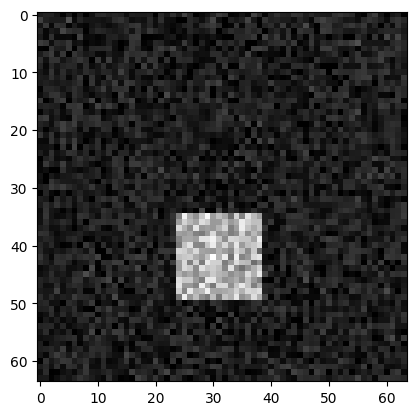

In [6]:
# plot some info
img, coord = dataset[2512]

print(f'coord = {coord}')
plt.imshow(img.numpy()[0], cmap='gray')

In [7]:
# split data
train_data, val_data, test_data = random_split(dataset, [0.7, 0.1, 0.2])

In [8]:
# split data on batches
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

#### Create model

In [9]:
class MyModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        return out

In [10]:
model = MyModel(64 * 64, 2).to(device)

In [11]:
# check
input = torch.rand([16, 64 * 64], dtype=torch.float32).to(device)

out = model(input)
out.shape

torch.Size([16, 2])

In [12]:
# set up loss and GD optimizer
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

#### Create train cycle

In [13]:
EPOCHS = 30
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# training cycle
for epoch in range(EPOCHS):

    # train model
    model.train() # set up train mode
    # save loss
    running_train_loss = []
    # add metric calc(accuracy)
    true_answer = 0
    # add progress bar
    train_loop = tqdm(train_loader, leave=False)
    for x, targets in train_loop:
        # data
        # (batch_size, 1, 64, 64) -> (batch_size, 64 * 64)
        x = x.reshape(-1, 64 * 64).to(device)
        targets = targets.to(device)
        
        # forward pass + loss calc
        pred = model(x)
        loss = loss_model(pred, targets)

        # backward pass
        opt.zero_grad()
        loss.backward()
        # optimizer step
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()
        
        # add description to progress bar
        train_loop.set_description(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}')

    # calc metric(accuracy)
    running_train_accuracy = true_answer / len(train_data)
    
    # save loss and metric
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_accuracy)
    
    # validation
    model.eval() # set up model into validation mode
    with torch.no_grad(): # disable gradient calculation
        # do the same for loss on validation
        running_val_loss = []
        true_answer = 0
        for x, targets in val_loader:
            # Data
            # (batch_size, 1, 64, 64) -> (batch_size, 64 * 64)
            x = x.reshape(-1, 64 * 64).to(device)
            targets = targets.to(device)

            # forward pass + loss calc
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss) / len(running_val_loss)

            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()
            
        # calc metric(accuracy)
        running_val_acc = true_answer / len(val_data)
            
        # save loss and metric
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)

        print(f'Epoch [{epoch + 1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}, train_acc = {running_train_accuracy:.4f}, val_loss = {mean_val_loss:.4f}, val_acc = {running_val_acc:.4f}')

Epoch [1/30], train_loss = 1.8393, train_acc = 0.6461, val_loss = 0.0720, val_acc = 0.8785


Epoch [2/30], train_loss = 0.1409, train_acc = 0.6723, val_loss = 0.0691, val_acc = 0.8911


Epoch [3/30], train_loss = 0.1243, train_acc = 0.7222, val_loss = 0.0905, val_acc = 0.8204


Epoch [4/30], train_loss = 0.1068, train_acc = 0.7712, val_loss = 0.0611, val_acc = 0.9147


Epoch [5/30], train_loss = 0.0935, train_acc = 0.8143, val_loss = 0.0606, val_acc = 0.9195


Epoch [6/30], train_loss = 0.0806, train_acc = 0.8542, val_loss = 0.0817, val_acc = 0.8404


Epoch [7/30], train_loss = 0.0769, train_acc = 0.8672, val_loss = 0.1375, val_acc = 0.6755


Epoch [8/30], train_loss = 0.0695, train_acc = 0.8884, val_loss = 0.0495, val_acc = 0.9511


Epoch [9/30], train_loss = 0.0657, train_acc = 0.9014, val_loss = 0.0427, val_acc = 0.9652


Epoch [10/30], train_loss = 0.0635, train_acc = 0.9076, val_loss = 0.0518, val_acc = 0.9527


Epoch [11/30], train_loss = 0.0600, train_acc = 0.9177, val_loss = 0.0532, val_acc = 0.9368


Epoch [12/30], train_loss = 0.0568, train_acc = 0.9264, val_loss = 0.0587, val_acc = 0.9224


Epoch [13/30], train_loss = 0.0554, train_acc = 0.9311, val_loss = 0.0470, val_acc = 0.9570


Epoch [14/30], train_loss = 0.0538, train_acc = 0.9365, val_loss = 0.0396, val_acc = 0.9676


Epoch [15/30], train_loss = 0.0521, train_acc = 0.9410, val_loss = 0.0635, val_acc = 0.9037


Epoch [16/30], train_loss = 0.0506, train_acc = 0.9444, val_loss = 0.0364, val_acc = 0.9799


Epoch [17/30], train_loss = 0.0495, train_acc = 0.9454, val_loss = 0.0396, val_acc = 0.9746


Epoch [18/30], train_loss = 0.0483, train_acc = 0.9505, val_loss = 0.0442, val_acc = 0.9576


Epoch [19/30], train_loss = 0.0472, train_acc = 0.9537, val_loss = 0.0403, val_acc = 0.9688


Epoch [20/30], train_loss = 0.0465, train_acc = 0.9542, val_loss = 0.0676, val_acc = 0.8918


Epoch [21/30], train_loss = 0.0461, train_acc = 0.9552, val_loss = 0.0558, val_acc = 0.9298


Epoch [22/30], train_loss = 0.0448, train_acc = 0.9584, val_loss = 0.0379, val_acc = 0.9807


Epoch [23/30], train_loss = 0.0450, train_acc = 0.9577, val_loss = 0.0331, val_acc = 0.9824


Epoch [24/30], train_loss = 0.0438, train_acc = 0.9607, val_loss = 0.0454, val_acc = 0.9556


Epoch [25/30], train_loss = 0.0434, train_acc = 0.9611, val_loss = 0.0374, val_acc = 0.9766


Epoch [26/30], train_loss = 0.0424, train_acc = 0.9637, val_loss = 0.0512, val_acc = 0.9407


Epoch [27/30], train_loss = 0.0424, train_acc = 0.9639, val_loss = 0.0424, val_acc = 0.9677


Epoch [28/30], train_loss = 0.0413, train_acc = 0.9663, val_loss = 0.0482, val_acc = 0.9601


Epoch [29/30], train_loss = 0.0407, train_acc = 0.9671, val_loss = 0.0676, val_acc = 0.9043


Epoch [30/30], train_loss = 0.0405, train_acc = 0.9686, val_loss = 0.0470, val_acc = 0.9658


#### Plot results

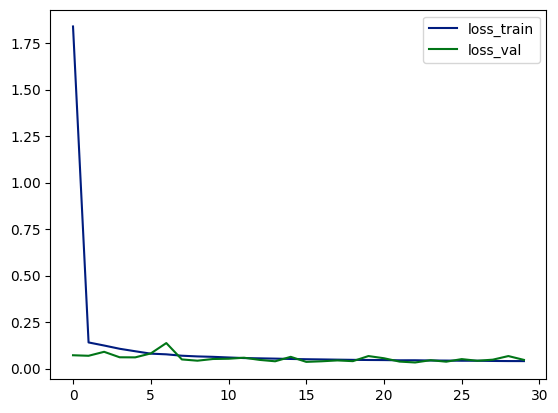

In [14]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

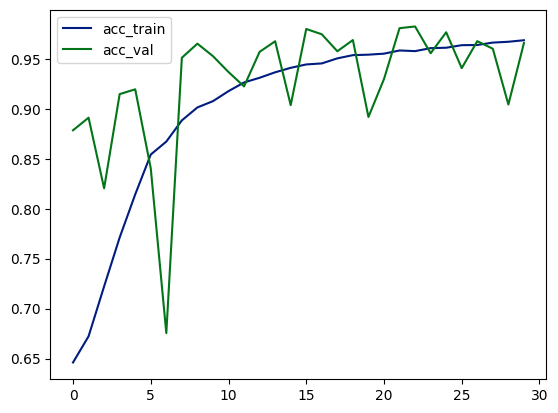

In [15]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['acc_train', 'acc_val'])
plt.show()